In [121]:
__author__ = 'nipunbatra'

import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv("../main_15min_decomposition_12_daily_weekly_cluster_diff_frac_temp_weekday_hvac_energy_fft.csv",index_col=0)
dfc = df.copy()

df = df.drop(871)
df = df.drop(1169)



w=df[['aggregate_%d' %i for i in range(1,13)]]

df = df.ix[w[w>0].dropna().index]

"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',}
                       #'month_extract':['variance','ratio_min_max', 'difference_min_max',
                        #                'ratio_difference_min_max']}

"""
features_individual = {'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       'trend_12':['stdev_trend_12','max_trend_12'],

                       'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],
                       'cluster_big':'cluster_big',
                       'cluster_small':'cluster_small',
                       'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'week':["fraction_%d" % i for i in range(1, 8)],
                       #'disag_fridge':'disag_fridge'}
                       'mins_hvac':'mins_hvac',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}

### Monthly ONLY
"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       #'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       #'trend_12':['stdev_trend_12','max_trend_12'],
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       #'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       #'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',
                       #'cluster_big':'cluster_big',
                       #'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}


"""

from itertools import combinations
features_dict = {}
for feature_size in range(1,max(4,len(features_individual))):
    combinations_size_n = list(combinations(features_individual.keys(), feature_size))
    for com in combinations_size_n:
        features_dict[com] = np.hstack([features_individual[x] for x in com]).tolist()



hvac_fhmm_pred = pd.read_csv("../fhmm_disag_new.csv", index_col=0)
fridge_fhmm_pred = pd.read_csv("../fridge_fhmm.csv", index_col=0)
appliance_fhmm = {'fridge': fridge_fhmm_pred,
                  'hvac': hvac_fhmm_pred}

national_average = {"fridge": 0.07, "hvac": 0.18, 'wm': 0.01, 'furnace': 0.09, 'dw': 0.02, 'dr': 0.04, 'light': .11}


def scale_0_1(ser, minimum=None, maximum=None):
    if minimum is not None:
        pass
    else:
        minimum = ser.min()
        maximum = ser.max()
    return (ser-minimum).div(maximum-minimum)

#Normalising features
max_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].max().max()
min_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].min().min()
df[["aggregate_%d" % i for i in range(1, 13)]] = scale_0_1(df[["aggregate_%d" % i for i in range(1, 13)]], min_aggregate, max_aggregate)


max_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].max().max()
min_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].min().min()
df[["daily_usage_%d" % i for i in range(1, 8)]] = scale_0_1(df[["daily_usage_%d" % i for i in range(1, 8)]], min_weekly, max_weekly)

df['area'] = scale_0_1(df['area'])

df['num_rooms'] = scale_0_1(df['num_rooms'])
df['total_occupants'] = scale_0_1(df['total_occupants'])
df['mins_hvac'] =  scale_0_1(df['mins_hvac'])

# Adding new feature
aa = df[["aggregate_%d" % i for i in range(1, 13)]].copy()
df['variance'] = df[["aggregate_%d" % i for i in range(1, 13)]].var(axis=1)
df['ratio_min_max'] = aa.min(axis=1)/aa.max(axis=1)


df['difference_min_max'] = aa.max(axis=1)-aa.min(axis=1)
df['ratio_difference_min_max'] = (aa.max(axis=1)-aa.min(axis=1)).div(aa.max(axis=1))


for col in ["stdev_trend_12","stdev_seasonal_12","max_seasonal_12","max_trend_12",
            "stdev_trend_daily","stdev_seasonal_daily","max_seasonal_daily","max_trend_daily",
            "stdev_trend_weekly","stdev_seasonal_weekly","max_seasonal_weekly","max_trend_weekly","disag_fridge",
            'stdev_trend','stdev_seasonal','max_seasonal','max_trend',
            'cluster_small','cluster_big', 'temperature_corr', 'variance',
            'ratio_min_max','ratio_difference_min_max',
            #'seasonal_energy_5','seasonal_energy_6',
            #'seasonal_energy_7','seasonal_energy_8','seasonal_energy_9','seasonal_energy_10',
           'fft_1','fft_2','fft_3','fft_4','fft_5']:
    if col in df.columns:

        df[col] = scale_0_1(df[col])



dfs = {}
total = features_dict.values()[np.array(map(len, features_dict.values())).argmax()]
for appliance in ['fridge','hvac','dr','light','dw','wm']:
    temp=df.ix[df[['%s_%d' %(appliance, i) for i in range(1,13)]].dropna().index]
    dfs[appliance] =temp.ix[temp[total].dropna().index]
    print appliance, len(dfs[appliance])

appliance_min = {'fridge':5,'hvac':5,'wm':0,'dw':0,'dr':0,'light':0}

all_homes = {
    'dw':[  94,  370,  545,  624, 2156, 2242, 2814, 2829, 3723,
            4767, 5357,6636, 6910, 7769, 9934],
    'wm':[  94,  370,  545,  624, 2156, 2242, 2814, 3367, 3456, 3723, 3967,
            5357, 7769, 9654, 9922, 9934],
    'hvac':[  26,   94,  370,  410,  545,  624, 1283, 1642, 1953, 2129,
            2156, 2242, 2470, 2814, 2829,  3367, 3456, 3723,
            3967, 4767, 5218, 5357, 5371, 5746, 5785, 5814, 6072,
            6636, 6836, 6910, 7731, 7769, 7866, 9609, 9654, 9922, 9933, 9934],
    'fridge':[  94,  370,  410,  545,  624, 1953, 2156, 2242, 2814, 2829, 3367,
            3456, 3723, 3967, 4767, 5357, 5371, 6072, 6636, 6910, 7769, 7866],
    'light':df.index.tolist(),
        #[ 624, 1334, 2814, 2925, 2986, 3367, 3456, 3482, 3723, 3967, 4732,
        #    4767, 5814, 5817, 6072, 6266, 6910, 7016, 7429, 7731, 7769, 7866,
        #    8317, 8626, 9052, 9654, 9922],
    'dr':[  94,  370,  410, 2156, 2242, 2814, 3456, 3723, 4767,
            5785, 5814, 6072, 6636, 6836, 7731, 7769, 7866, 9654, 9922,
            9933, 9982]
}

all_homes = {appliance:dfs[appliance].index for appliance in dfs.keys()}

all_homes['fridge'] = np.array(np.setdiff1d(all_homes['fridge'], [2233, 5746, 7016]))
all_homes['hvac'] = np.array(np.setdiff1d(all_homes['hvac'], [252, 2925, 2986, 3482, 4732, 5439, 6266,
                                                              8626, 1800, 2233, 5817, 7016, 7429, 8317,
                                                              9052, 9982]))

all_homes['dw'] =  np.array(np.setdiff1d(all_homes['dw'],[2233, 7016]))

all_homes['wm'] = np.array([  94,  370,  545,  624, 2156, 2242, 2470, 2814, 3367, 3456, 3723,
            3967, 5357, 7769, 9654, 9922, 9934])

all_homes['light']=[624, 1334, 3367, 3456, 3723, 5814, 6072, 6910, 7769, 7866, 9654,
            9922]

def create_predictions(appliance="hvac", feature=['num_rooms', 'total_occupants'],k=2, weights='uniform'):
    
   
    out_month = {}
    gt_month = {}
    overall_dfs = {}
    df_pred_copy = df.copy()
    #df_pred_copy = dfs[appliance].copy()
    df_pred_copy = df_pred_copy.ix[all_homes[appliance]]
    for i, month in enumerate(["%s_%d" %(appliance,i) for i in range(1,13)]):
        y = df_pred_copy[month]
        y2 = y.dropna()
        y3 = y2[y2>appliance_min[appliance]].dropna()
        df3 = df_pred_copy[feature].ix[y3.index].dropna()
        
        #df3 = df.ix[y3.index].dropna()
        y3 = y3.ix[df3.index]
        #df3 = df3.ix[appliance_fhmm[appliance].index].dropna()
        #y3 = y3.ix[df3.index]
        from sklearn.cross_validation import LeaveOneOut
        from sklearn.neighbors import RadiusNeighborsRegressor
        #clf = RadiusNeighborsRegressor(radius=k)
        clf = KNeighborsRegressor(n_neighbors=k, weights=weights)
        #clf = KNeighborsRegressor(n_neighbors=k, weights = 'distance' )
        loo = LeaveOneOut(len(df3))
        out_pred = []

        for train, test in loo:
            #clf.fit(preprocessing.normalize(df3[feature_columns[feature]].values[train]), y3.values[train])
            clf.fit(df3[feature].values[train], y3.values[train])
            #out_pred.append(clf.predict(preprocessing.normalize(df3[feature_columns[feature]].values[test])))
            out_pred.append(clf.predict(df3[feature].values[test]))

        out_pred = np.hstack(out_pred)

        out_month[i+1] = out_pred
        gt_month[i+1] = y3.values
        overall_dfs[i+1] = pd.DataFrame({"gt":y3.values, "pred":out_pred,
                                              "gt_total":dfc.ix[y3.index]["aggregate_"+str(i+1)].values}, index=y3.index)
        overall_dfs[i+1]["national average"] = overall_dfs[i+1]["gt_total"]*national_average[appliance]
    return overall_dfs

def percentage_error(gt, pred):
    return 100*np.abs(gt-pred)/(gt)




def compute_metrics(df):
    temp = df[df.gt_total>0.0]
    temp = temp[temp.gt>temp.gt_total]
    return {"Percentage error in appliance energy":np.median(percentage_error(df["gt"], df["pred"]))
            }



fridge 30
hvac 44
dr 32
light 21
dw 28
wm 26


In [160]:
df

aggregate_1  aggregate_2  aggregate_3  aggregate_4  aggregate_5  \
26       0.134430     0.089842     0.087678     0.122620     0.288130   
94       0.143181     0.081962     0.093821     0.080206     0.097667   
252      0.457861     0.229885     0.382532     0.433377     0.772610   
370      0.255465     0.230236     0.212220     0.217418     0.404339   
410      0.068456     0.030526     0.029259     0.041942     0.097779   
545      0.192407     0.182138     0.211784     0.191359     0.377628   
624      0.125368     0.037204     0.030524     0.040147     0.075879   
1283     0.258354     0.250395     0.233006     0.196870     0.334544   
1334     0.054625     0.025869     0.056798     0.058401     0.039037   
1642     0.103701     0.099653     0.170967     0.174323     0.316799   
1800     0.179112     0.117577     0.146523     0.133470     0.256786   
1953     0.087916     0.062945     0.054233     0.063626     0.097751   
2129     0.252741     0.180601     0.230724     0.241491     0.340880   
2156     0.225887     0.169340     0.275184     0.201350     0.306517   
2233     0.100580     0.073841     0.094651     0.093660     0.191889   
2242     0.409781     0.252875     0.343166     0.354170     0.566372   
2470     0.095223     0.068689     0.062368     0.058555     0.096042   
2814     0.186413     0.170097     0.245559     0.262647     0.416523   
2829     0.150473     0.135955     0.141002     0.151651     0.225363   
2925     0.101101     0.094264     0.098213     0.162194     0.345922   
2986     0.015077     0.000000     0.029585     0.024871     0.089456   
3224     0.067805     0.067750     0.066925     0.053044     0.078478   
3367     0.217082     0.190093     0.222603     0.213483     0.341161   
3456     0.080311     0.051614     0.047468     0.056779     0.116370   
3482     0.082867     0.050851     0.060461     0.068790     0.135772   
3723     0.136657     0.116723     0.127468     0.115857     0.201557   
3967     0.180991     0.150121     0.191554     0.156388     0.255317   
4732     0.066982     0.050953     0.067493     0.033149     0.070024   
4767     0.170472     0.148790     0.170166     0.163741     0.311735   
5218     0.091363     0.070911     0.081114     0.086328     0.125009   
5357     0.928494     0.719195     0.736461     0.718856     0.759478   
5371     0.135877     0.093736     0.132612     0.192347     0.274308   
5439     0.136344     0.075150     0.098349     0.095797     0.138727   
5746     0.178093     0.130974     0.149107     0.188732     0.308979   
5785     0.202795     0.178333     0.200579     0.242126     0.286748   
5814     0.038108     0.026364     0.031768     0.052432     0.114588   
5817     0.250108     0.173850     0.198528     0.231025     0.324716   
6072     0.195143     0.165760     0.156874     0.208757     0.264533   
6266     0.204017     0.179107     0.218660     0.211037     0.332104   
6636     0.083205     0.026428     0.036682     0.027225     0.130496   
6836     0.082428     0.079019     0.064839     0.021278     0.069714   
6910     0.155814     0.138949     0.138041     0.143576     0.259023   
7016     0.379971     0.305081     0.414087     0.411260     0.605130   
7429     0.177258     0.140612     0.171555     0.197811     0.316445   
7731     0.109622     0.069879     0.096420     0.106822     0.198694   
7769     0.059944     0.024792     0.029324     0.030000     0.072559   
7850     0.163564     0.151898     0.172855     0.177988     0.294334   
7866     0.064503     0.042257     0.054633     0.065353     0.131180   
8317     0.126038     0.086592     0.105371     0.134197     0.189728   
8626     0.165396     0.087577     0.100458     0.097306     0.143137   
9052     0.134487     0.100820     0.123435     0.139964     0.266133   
9609     0.255927     0.126403     0.294123     0.196621     0.150067   
9654     0.031256     0.009277     0.010551     0.021189     0.071352   
9922     0.451495     0.397279     0.463080     0.516261     0.1

In [143]:
a = df.ix[all_homes["hvac"]][['aggregate_5','hvac_5','seasonal_energy_5']]

In [144]:
a['seasonal_energy_5'] = a['seasonal_energy_5'].mul(0.000017).mul(15)

In [145]:
b = 100 -(a['seasonal_energy_5']-a['hvac_5']).abs().div(a['hvac_5'])*100

In [146]:
b[b<0] = 0


In [149]:
a

aggregate_5      hvac_5  seasonal_energy_5
26       0.288130  252.918915         705.949531
94       0.097667   35.342098         299.600300
370      0.404339  275.581604         777.504518
410      0.097779  145.884659         333.599813
545      0.377628  379.723541         690.213836
624      0.075879   78.739754         262.799557
1283     0.334544  371.440918         438.778243
1334     0.039037    0.337807         139.857984
1642     0.316799  185.528671         531.988524
1953     0.097751  112.348465         472.127399
2129     0.340880  344.335083         633.825077
2156     0.306517  307.734283         677.362834
2242     0.566372  562.330017        1069.106885
2814     0.416523  280.611938         840.784987
3367     0.341161  290.180817         834.564344
3456     0.116370  171.610168         302.390904
3723     0.201557  184.446747         529.991662
3967     0.255317  314.295502         572.660090
4767     0.311735  307.931763         606.007857
5357     0.759478  671.812927        1496.666603
5371     0.274308  347.617157         504.479967
5746     0.308979  345.579620         461.676796
5785     0.286748  231.598862         448.813540
5814     0.114588  199.986572         331.323781
6072     0.264533  188.112564         574.257772
6636     0.130496  233.812836         427.881781
6836     0.069714   41.467964         350.025184
6910     0.259023  246.079544         666.127432
7731     0.198694  251.457565         498.443613
7769     0.072559   84.557220         291.640056
7866     0.131180  163.453049         335.282811
9654     0.071352  130.144516         339.232548
9922     0.167925   97.669960         953.392470
9933     0.324978  199.874130         528.266066
9934     0.227986  310.352692         722.823681

In [153]:
appliance="hvac"
feature_set = ['aggregate_7', 'aggregate_11', 'aggregate_1', 'difference_min_max', 'aggregate_10', 'aggregate_6', 'seasonal_energy_6', 'seasonal_energy_9']
k=5
temp = create_predictions(appliance, feature_set, k)
errors = {}
upper_threshold = 0.8
lower_threshold = 0.2
for i in range(1, 13):
    
    print i
    print "*"*80
    fraction_of_aggregate = temp[i]["pred"].div(temp[i]["gt_total"])
    gt_ratio = temp[i]["gt"].div(temp[i]["gt_total"])
    upper_threshold = gt_ratio.max()

    lower_threshold = gt_ratio.min()
    print upper_threshold, lower_threshold
    upper = fraction_of_aggregate[fraction_of_aggregate>upper_threshold]
    lower = fraction_of_aggregate[fraction_of_aggregate<lower_threshold]
    if 5<=i<=10:
        print upper
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

if appliance is "hvac":
     tdf = accur_df[range(5, 11)]
else:
    tdf = accur_df


1
********************************************************************************
0.351098001501 0.0107142856929
2
********************************************************************************
0.194003105572 0.0103785844164
3
********************************************************************************
0.179506324278 0.00594098101395
4
********************************************************************************
0.208519423236 0.0345390367466
5
********************************************************************************
0.446444152547 0.0821296650888
1953    0.718918
6636    0.537913
6836    0.462426
9922    0.545550
dtype: float64
6
********************************************************************************
0.659243783708 0.145107928239
1334    0.945658
6836    0.688024
9654    0.736753
9934    1.238807
dtype: float64
7
********************************************************************************
0.681607109224 0.103052308246
1334    1.097787
6836    0.766315
776

In [159]:
temp[6]

gt     gt_total        pred  national average
26     624.465027  1459.766235  636.856378        262.757922
94     118.666191   587.913879  364.013354        105.824498
370    815.937805  1909.641357  693.590546        343.735444
410    459.637848   775.190308  417.828378        139.534255
545    955.640015  1940.215088  570.621381        349.238716
624    315.469696   613.537170  324.652654        110.436691
1283   506.097961  1137.184814  692.030298        204.693267
1334    45.392380   312.818054  295.819023         56.307250
1642   502.067932  1505.754517  528.266498        271.035813
1953   638.533630  1132.591797  624.505530        203.866523
2129   789.619019  1703.049683  649.260608        306.548943
2156   608.746460  1295.901611  640.000092        233.262290
2242  1240.620972  2764.422607  647.362982        497.596069
2814   779.891052  1933.542480  682.512775        348.037646
3367   824.413208  1898.846680  673.608344        341.792402
3456   452.101501   840.551270  332.310942        151.299229
3723   496.093384  1358.322998  529.461407        244.498140
3967  1085.205322  2171.584229  558.679724        390.885161
4767   579.574158  1386.219482  668.738965        249.519507
5357  1293.008301  2589.279785  838.778491        466.070361
5371   694.897278  1348.539185  567.506537        242.737053
5746   672.633423  1502.431641  617.685571        270.437695
5785   645.109009  1387.668823  664.228088        249.780388
5814   490.392944   828.075439  411.677359        149.053579
6072   426.044128  1149.934570  690.511963        206.988223
6636   808.978149  1227.130493  631.454260        220.883489
6836   236.286148   672.213013  462.498718        120.998342
6910   546.732971  1117.138794  652.402789        201.084983
7731   603.789978  1152.197876  550.419989        207.395618
7769   292.214630   592.009460  329.303667        106.561703
7866   609.718201  1082.646729  387.812308        194.876411
9654   300.643097   610.282593  449.627328        109.850867
9922   533.029419  1197.912720  788.881293        215.624290
9933   420.507721  1008.866455  587.076440        181.595962
9934   283.543427   573.377930  710.304456        103.208027

In [150]:
tdf

5          6          7          8          9          10
26    99.705263  93.330686  97.846767  95.955195  99.090524  87.803512
94     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
370   83.679961  96.309729  98.433852  86.562345  88.240866  83.565380
410   96.879586  90.903824  83.353758  84.916101  89.707814  93.733280
545   79.268456  89.888794  94.140134  87.391212  98.671209  75.082467
624   66.789168  99.365156  83.627611  93.229809  91.291404  65.390499
1283  67.579289  85.576385  88.477793  62.069050  61.301476  47.223661
1334        NaN   0.000000   0.000000   0.000000   0.000000        NaN
1642  52.921302  78.802305  72.096727  84.639883  92.333772  88.521010
1953   0.000000  98.284293  96.357298  87.020706  73.238363  28.732992
2129  91.002390  91.492317  92.144749  99.731789  95.706670  83.951387
2156  69.633574  82.590812  98.080627  97.498376  99.656901  94.419791
2242  47.081529  63.015403  73.551740  82.980531  86.204580  88.158813
2814  90.044596  97.163198  95.162915  93.724668  90.493385  65.918398
3367  90.538324  95.114004  93.366402  99.781911  96.561734  96.975985
3456  69.485797  79.735623  97.088811  96.914673  84.595302  96.106630
3723  66.567767  88.408273  53.476442  92.550464  94.897744  65.377931
3967  97.728338  68.187123  97.914931  77.246013  86.789499  17.128055
4767  97.411400  93.201471  88.616735  92.923416  94.130760  95.625643
5357  44.845054  64.870310  69.055170  74.486108  59.637200  45.799556
5371  58.382987  92.056159  97.319247  94.619601  93.303646  96.269565
5746  85.683333  93.298700  93.081646  91.537350  80.151572  59.718601
5785  86.156990  89.889699  84.759693  92.200887  84.726829  93.047338
5814  65.260417  83.948467  80.788579  99.030041  97.449522  95.372531
6072  64.269857  63.345754  62.879940  60.559948  39.759855   0.000000
6636  94.646224  78.915558  86.141274  81.933560  87.911201  99.841824
6836   0.000000  74.804755  63.285344  84.305987  57.020922  67.433622
6910  96.371440  98.849578  80.924876  85.867097  81.003234  94.312912
7731  89.498317  93.737031  95.827018  91.425074  78.684459  66.930387
7769  91.835494  97.405570  73.134801  87.585500  64.257661  12.073778
7866  94.325287  93.474135  91.268183  91.306056  80.661397  96.509911
9654  97.997078  70.019425  95.675879  94.714781  71.821564  63.669310
9922   0.000000  52.000422  93.910996  95.407971  65.216233   0.000000
9933  86.815306  56.917061  71.575666  64.408976  69.194528  93.315755
9934  91.592508  11.866866  79.927699  89.827836  91.734801  88.651038

In [120]:
tdf[tdf>20].dropna().mean().mean()

84.985881775177674

In [37]:
errors = {}
for i in range(1, 13):
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

In [41]:
accur_df[range(5, 11)].dropna().mean(axis=1)

26      86.845173
94       0.000000
370     91.996613
410     88.233508
545     87.317882
624     79.884665
1283    53.382392
1642    66.330533
1953    37.442531
2129    81.827711
2156    92.281127
2242    89.182654
2814    85.355460
3367    95.282843
3456    89.575884
3723    62.121045
3967    63.494987
4767    83.689384
5357    65.107652
5371    75.323792
5746    81.594823
5785    82.401045
5814    91.611564
6072    28.117228
6636    88.060260
6836    30.974716
6910    88.852455
7731    86.889797
7769    69.660017
7866    87.366189
9654    67.677484
9922    55.043710
9933    73.257491
9934    29.893828
dtype: float64

In [38]:
accur_df[range(5, 11)].dropna().median().mean()

80.639355246026469

In [12]:
len(accur_df.dropna().mean(axis=1).index)

5

In [13]:
accur_df.dropna().median().mean()

45.621964788405982

In [14]:
accur_df.dropna().mean(axis=1).index

Int64Index([2156, 2242, 5357, 9922, 9934], dtype='int64')

In [116]:
all_homes["wm"]

array([  94,  370,  545,  624, 2156, 2242, 2470, 2814, 3367, 3456, 3723,
       3967, 5357, 7769, 9654, 9922, 9934])

In [191]:
accur_df.dropna().mean(axis=1)

624     66.338298
1334    60.475478
3367    40.194637
3456    75.321789
3723    59.460502
5814     8.401583
6072    52.053419
6910    10.204015
7769    42.333597
7866     0.000000
9654     3.394330
9922    74.324162
dtype: float64

In [16]:
%matplotlib inline

fft_5    hvac_6
fft_5   1.000000  0.118956
hvac_6  0.118956  1.000000

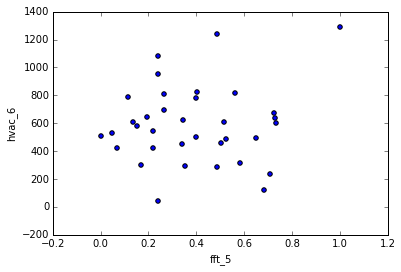

In [22]:
m=6
wm = 'hvac_%d' %m
feature_plot="fft_5"
df.ix[all_homes["hvac"]][[feature_plot,wm]].plot(kind="scatter", x=feature_plot,y=wm)
df.ix[all_homes["hvac"]][[feature_plot,wm]].corr()

In [133]:
temp = create_predictions('wm',['area'],1)
errors = {}
for i in range(1, 13):
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

In [136]:
accur_df.dropna().median()

1     75.396849
2     54.210730
3     70.017919
4     76.092595
5     67.051359
6     72.371640
7     61.919578
8     52.771398
9     49.699680
10    49.753408
11    51.554367
12    57.104109
dtype: float64

In [272]:
all_homes['dw']

array([  94,  370,  545,  624, 1642, 2156, 2242, 2470, 2814, 2829, 3367,
       3456, 3723, 3967, 4767, 5357, 6072, 6636, 6910, 7769, 7850, 9922,
       9934])

In [318]:
st = pd.HDFStore("/Users/nipunbatra/Downloads/wiki-temp.h5")
out_dw = {}
for home in all_homes['dw']:
    a = st['/%d' %home]['2013']['dishwasher1'].resample("15T")
    print home
    out_dw[home] = {'bet_500_1000':len(a.diff().abs()[(a.diff().abs()>500) & (a.diff().abs()<1000)]),
                    'gt_1000':len(a.diff().abs()[(a.diff().abs()>1000)])}

94
370
545
624
1642
2156
2242
2470
2814
2829
3367
3456
3723
3967
4767
5357
6072
6636
6910
7769
7850
9922
9934


In [313]:
df.ix[all_homes['dw']].bet_500_1000

94      0.114616
370     0.108364
545     0.168227
624     0.135370
1642    0.116700
2156    0.136198
2242    0.120325
2470    0.094376
2814    0.102279
2829    0.065801
3367    0.134742
3456    0.129175
3723    0.119355
3967    0.105681
4767    0.147731
5357    0.180274
6072    0.088638
6636    0.026292
6910    0.053754
7769    0.070911
7850    0.075657
9922    0.090751
9934    0.208136
Name: bet_500_1000, dtype: float64

In [319]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.scatter(pd.Series(out_dw), df.ix[all_homes['dw']].bet_500_1000)
#.corr(df.ix[all_homes['dw']].bet_500_1000)

TypeError: float() argument must be a string or a number

TypeError: float() argument must be a string or a number

In [339]:
pd.Series(out_dw['bet_500_1000']).corr(df.ix[all_homes['dw']].bet_500_1000)

KeyError: 'bet_500_1000'

In [340]:
pd.DataFrame(out_dw).T.corrwith(df.ix[all_homes['dw']].bet_500_1000)

bet_500_1000    0.631211
gt_1000         0.273902
dtype: float64

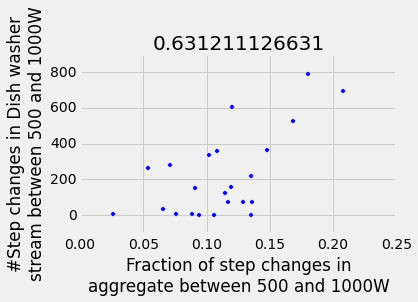

In [350]:
plt.scatter(df.ix[all_homes['dw']].bet_500_1000, pd.DataFrame(out_dw).T['bet_500_1000'])
plt.xlabel("Fraction of step changes in \naggregate between 500 and 1000W")
plt.ylabel("#Step changes in Dish washer \nstream between 500 and 1000W")
plt.title(df.ix[all_homes['dw']].bet_500_1000.corr(pd.DataFrame(out_dw).T['bet_500_1000']))
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/dw_aggregate_step_changes.png")

In [338]:
df.ix[all_homes['dw']]['dw_5']

94       4.389723
370     26.143587
545     18.027090
624     20.888189
1642     0.000000
2156     3.560072
2242    19.654873
2470     0.012189
2814    11.864521
2829     7.631028
3367     0.244341
3456     0.835023
3723    35.810143
3967     0.048807
4767     9.052568
5357    16.497515
6072     0.008568
6636     1.574064
6910    13.312785
7769     6.195429
7850     0.000000
9922     0.722194
9934    41.853798
Name: dw_5, dtype: float64